In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.utils.np_utils import to_categorical  
from keras import regularizers

from constants import img_size, train_data_dir, dev_data_dir, epochs, batch_size, num_class

Using TensorFlow backend.


## Callbacks

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')
            
checkpoint = keras.callbacks.ModelCheckpoint(
    './model_1/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=True, 
    mode='auto', 
    period=1,
)

## Top Model

In [3]:
train_data = np.load('./data/bottleneck_features/vgg19/bottleneck_features_train.npy')
dev_data = np.load('./data/bottleneck_features/vgg19/bottleneck_features_dev.npy')
train_labels = np.load('./data/bottleneck_features/vgg19/train_labels.npy')
dev_labels = np.load('./data/bottleneck_features/vgg19/dev_labels.npy')

In [4]:
inputs = Input(shape=(train_data.shape[1], train_data.shape[2], train_data.shape[3]))
X = Flatten()(inputs)
X = Dense(2048, activation='relu')(X)
X = Dropout(0.2)(X)
X = Dense(1024, activation='relu')(X)
#X = Dropout(0.2)(X)
outputs = Dense(
    num_class, 
    activation='softmax', 
    #activity_regularizer=regularizers.l2(100.)
)(X)

top_model = Model(inputs=inputs, outputs=outputs)

top_model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

plot_losses = PlotLosses()

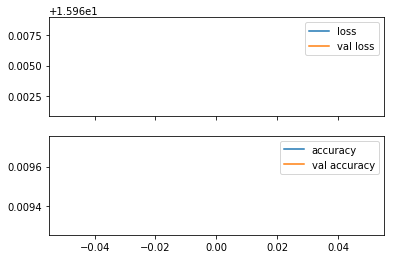

Epoch 1
-----------------------
- Loss: 15.9612154231
- Accuracy: 0.00973315835521
- Validation loss: 15.9685768878
- Validation accuracy: 0.00927643784787
 
Epoch 2/50
 296/9144 [..............................] - ETA: 4:21 - loss: 16.0636 - categorical_accuracy: 0.0034    

KeyboardInterrupt: 

In [7]:
top_model.fit(
    train_data, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[plot_losses, checkpoint], 
    validation_data=(dev_data, dev_labels),
)